# Generador de imágenes con la info de un globo 3D para usar en Interpolación globos 3D a partir de polares.


In [1]:
%reset -f

In [2]:
# importamos las librerías que vamos a utilizar. Algunas contienen funciones desarrolladas para este proyecto
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib
import matplotlib.pyplot as plt



from sklearn.model_selection import GridSearchCV, train_test_split

from timeit import default_timer as timer

import sys
sys.path.append('C:/Users/vcatala/OneDrive/PhD UV/Artículos/interpolation')

import Funciones_big_data_v31
from importlib import reload
reload(Funciones_big_data_v31)

from Funciones_big_data_v31 import import_3D
from Funciones_big_data_v31 import n_smoothing
from Funciones_big_data_v31 import plot_balloon
from Funciones_big_data_v31 import plot_polars, calcular_frecuencias_iso_octava, seleccionar_columnas_frecuencias_iso, create_spl_image, save_image, data_frame_solo_polares_theta90
from Funciones_big_data_v31 import plot_polar_plane, frequency_vector, FR_pd_v2, normalize, create_spl_heatmap, data_frame_solo_polares, seleccionar_frecuencias_proximas_a_iso
from polar_non_polar_split_cart_v20 import polar_split, polar_reconstruction

# establecemos el tamoño de los gráficos de los gráficos de Matplotlib. El tamaño por defecto es muy pequeño
plt.rcParams['figure.figsize'] = [20, 10]




In [3]:
# funciones para reordenar un dataset en espiral: phi: 0, 180, 5, 185, 10, 190, ... y para cada phi si phi>=180 las thetas van en orden descendente

import pandas as pd

def reordenar_phi(IR_balloon, resol):
    # Crea la secuencia de ordenación de phi: 0, 180, 5, 185, 10, 190, ...
    phi_order = []
    for i in range(36):
        phi_order.extend([i * resol, i * resol + 180])

    # Filtra el dataset para incluir solo los valores de phi en el orden especificado
    IR_balloon_reordenado = IR_balloon[IR_balloon['Phi'].isin(phi_order)]

    # Convierte la columna 'Phi' a tipo categoría con el orden específico
    IR_balloon_reordenado['Phi'] = pd.Categorical(IR_balloon_reordenado['Phi'], categories=phi_order, ordered=True)

    # Ordena el dataset basándose en la columna 'Phi'
    IR_balloon_reordenado = IR_balloon_reordenado.sort_values(by=['Phi'])

    return IR_balloon_reordenado

def reordenar_theta(IR_balloon_reordenado_phi, resol):
    # Inicializa una lista para almacenar el orden de theta
    
    # Inicializa el DataFrame final
    IR_balloon_reordenado = pd.DataFrame(columns=IR_balloon_reordenado_phi.columns)


    # Recorre el DataFrame por bloques de phi
    for phi_block in IR_balloon_reordenado_phi.groupby('Phi'):
        phi, phi_data = phi_block

        # Si phi es menor que 180, ordenar en orden ascendente
        if phi < 180:
            phi_data_sorted = phi_data.sort_values(by='Theta', ascending=True)
        # Si phi es mayor o igual a 180, ordenar en orden descendente
        else:
            phi_data_sorted = phi_data.sort_values(by='Theta', ascending=False)


        

        # Concatena el bloque ordenado al DataFrame final
        IR_balloon_reordenado = pd.concat([IR_balloon_reordenado, phi_data_sorted])


    # Asegurémonos de que la longitud sea la misma que la cantidad de filas en el DataFrame original
    #theta_order = theta_order[:len(IR_balloon_reordenado_phi)]

    # Asigna el orden de theta
    #IR_balloon_reordenado_phi['Theta'] = theta_order

    return IR_balloon_reordenado

def reordenar_phi_theta(IR_balloon, resol):
    # Utiliza la función reordenar_phi para obtener el DataFrame ordenado por phi
    IR_balloon_reordenado_phi = reordenar_phi(IR_balloon, resol)

    # Utiliza la función reordenar_theta para ordenar theta dentro de cada bloque de phi
    IR_balloon_reordenado_phi_theta = reordenar_theta(IR_balloon_reordenado_phi, resol)

    return IR_balloon_reordenado_phi_theta



In [4]:
# funciones para deshacer reordenar un dataset en espiral: phi: 0, 5, 10, 15, 20, 25, ... y para cada phi las thetas van en orden ascendente

import pandas as pd

def deshacer_reordenar_phi(IR_balloon, resol):
    # Crea la secuencia de ordenación de phi: 0, 180, 5, 185, 10, 190, ...
    phi_order = []
    for i in range(72):
        phi_order.extend([i * resol])

    # Filtra el dataset para incluir solo los valores de phi en el orden especificado
    IR_balloon_reordenado = IR_balloon[IR_balloon['Phi'].isin(phi_order)]

    # Convierte la columna 'Phi' a tipo categoría con el orden específico
    IR_balloon_reordenado['Phi'] = pd.Categorical(IR_balloon_reordenado['Phi'], categories=phi_order, ordered=True)

    # Ordena el dataset basándose en la columna 'Phi'
    IR_balloon_reordenado = IR_balloon_reordenado.sort_values(by=['Phi'])

    return IR_balloon_reordenado

def deshacer_reordenar_theta(IR_balloon_reordenado_phi, resol):
    # Inicializa una lista para almacenar el orden de theta
    theta_order = []

    # Recorre el DataFrame por bloques de phi
    for phi_block in IR_balloon_reordenado_phi.groupby('Phi'):
        phi, phi_data = phi_block

        # Si phi es menor que 180, ordenar en orden ascendente
        if phi < 180:
            theta_order.extend(range(0, 181, resol))
        # Si phi es mayor o igual a 180, ordenar en orden ascendente también
        else:
            theta_order.extend(range(0, 181, resol))

    # Asegurémonos de que la longitud sea la misma que la cantidad de filas en el DataFrame original
    theta_order = theta_order[:len(IR_balloon_reordenado_phi)]

    # Asigna el orden de theta
    IR_balloon_reordenado_phi['Theta'] = theta_order

    return IR_balloon_reordenado_phi

def deshacer_reordenar_phi_theta(IR_balloon, resol):
    # Utiliza la función reordenar_phi para obtener el DataFrame ordenado por phi
    IR_balloon_reordenado_phi = deshacer_reordenar_phi(IR_balloon, resol)

    # Utiliza la función reordenar_theta para ordenar theta dentro de cada bloque de phi
    IR_balloon_reordenado_phi_theta = deshacer_reordenar_theta(IR_balloon_reordenado_phi, resol)

    return IR_balloon_reordenado_phi_theta




In [5]:
import glob
import pandas as pd

def generar_imagenes(rootdir, resol, fft_size, fs, mode="normal", verbose=1):
    num_loudspeaker = 0

    for filepath in glob.glob(f'{rootdir}/*/'):
        print(filepath)

        # Intenta verificar si hay respuestas al impulso en la carpeta
        filename = (filepath + '/IR 0 0.txt')
        try:
            pd.read_csv(filename, delimiter='\s+')
        except:
            break
        else:
            print(filepath)
            num_loudspeaker += 1

            [IR_i, Fs] = import_3D(filepath, resol, verbose=verbose)
            FR = FR_pd_v2(IR_i, fft_size, fs)
            FR = normalize(FR)
            FR = seleccionar_columnas_frecuencias_iso(FR, 6, 100, 20000)

            if mode=='espiral':
                FR=reordenar_phi_theta(FR,resol)

            # Guarda la imagen antes de la modificación
            image = create_spl_image(FR)
            file_name_2=''
            if mode=='espiral':
                file_name_2='_esp'
            output_path = filepath + str(num_loudspeaker) + file_name_2 + '.png'
            image.save(output_path)

            FR_op = data_frame_solo_polares(FR)
            
            # Guarda la imagen después de la modificación
            image = create_spl_image(FR_op)
            file_name_2 = '_op'
            if mode=='espiral':
                file_name_2='_esp_op'
            output_path = filepath + str(num_loudspeaker) + file_name_2 + '.png'
            image.save(output_path)


            FR_op_90 = data_frame_solo_polares_theta90(FR)
            
            # Guarda la imagen después de la modificación
            image = create_spl_image(FR_op_90)
            file_name_2 = '90_op'
            if mode=='espiral':
                file_name_2='_esp_90_op'
            output_path = filepath + str(num_loudspeaker) + file_name_2 + '.png'
            image.save(output_path)




In [6]:
from PIL import Image
import os
import numpy as np

def cargar_dataset(ruta_carpeta, mode='normal'):
    entradas = []
    salidas = []

    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith(".png"):
            ruta_completa = os.path.join(ruta_carpeta, archivo)
            imagen = Image.open(ruta_completa)


            # quitamos las dos primeras columnas para quedarnos con imágenes de 44 columnas, para evitar problemas con downsampling upsamplin en la u-net
            # Convertir la imagen PIL a una matriz numpy
            imagen_array = np.array(imagen)

            # Eliminar las dos primeras columnas de la imagen
            imagen = imagen_array[:, 2:]/60   # dividido 60 para normalizar a 1

            # Convertir la matriz numpy de vuelta a una imagen PIL
            imagen = Image.fromarray(imagen)

            # Si la imagen es de entrada (only polars)
            if archivo.endswith("_op.png"):
              if archivo.endswith("_esp_op.png"):
                 if mode=='espiral':
                    entradas.append(np.array(imagen))
                    print('entradas')
                    print(archivo)
                    print(mode)

              else:
                if mode=='normal':
                    entradas.append(np.array(imagen))
                    print('entradas')
                    print(archivo)
                    print(mode)


            # Si la imagen es de salida
            else:
              if archivo.endswith("_esp.png"):
                 if mode=='espiral':
                    salidas.append(np.array(imagen))
                    print('salidas')
                    print(archivo)
                    print(mode)
              else:
                if mode=='normal':
                    salidas.append(np.array(imagen))
                    print('salidas')
                    print(archivo)
                    print(mode)

    return np.array(entradas), np.array(salidas)

In [7]:


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

def image_to_dataframe_espiral(image):
    # Obtener las dimensiones de la imagen
    height, width = image.shape

    # Crear índices para filas y columnas
    row_index = [f'Row_{i}' for i in range(height)]
    # col_index = [f'Col_{j}' for j in range(width)]
    col_index = ['128.90625',
       '140.625', '164.0625', '175.78125', '199.21875', '222.65625',
       '257.8125', '281.25', '316.40625', '351.5625', '398.4375', '445.3125',
       '503.90625', '562.5', '632.8125', '714.84375', '796.875', '902.34375',
       '1007.8125', '1136.71875', '1265.625', '1429.6875', '1605.46875',
       '1792.96875', '2015.625', '2261.71875', '2542.96875', '2847.65625',
       '3199.21875', '3597.65625', '4031.25', '4523.4375', '5074.21875',
       '5707.03125', '6398.4375', '7183.59375', '8062.5', '9046.875',
       '10160.15625', '11402.34375', '12796.875', '14367.1875', '16125.0',
       '18105.46875']

    # Crear el DataFrame con los índices
    #df = pd.DataFrame(index=row_index, columns=col_index)
    df = pd.DataFrame(columns=col_index)

    # Rellenar el DataFrame con los valores de los píxeles
    for i in range(height):
        for j in range(width):
            df.at[f'Row_{i}', col_index[j]] = (image[i, j])

        # Ahora completamos el df con las columnas de las coordenadas
    columns_names=['Phi','Theta','x', 'y', 'z']
    df.insert(0,'z', np.nan)
    df.insert(0,'y', np.nan)
    df.insert(0,'x', np.nan)
    df.insert(0,'Theta', np.nan)
    df.insert(0,'Phi', np.nan)

    print(df.shape)
    
    resol=5
    row=0
    for phi in range(0,180,resol):
        for theta in range(0,181,resol):

          cos = np.cos
          sin = np.sin
          deg2rad= np.deg2rad

          df['Phi'].iloc[row]=phi
          df['Theta'].iloc[row]=theta
          df['x'].iloc[row]=np.array(cos(deg2rad(phi))*sin(deg2rad(theta)))
          df['y'].iloc[row]=np.array(sin(deg2rad(phi))*sin(deg2rad(theta)))
          df['z'].iloc[row]= np.array(cos(deg2rad(theta)))

          print('row = ' + str(row))
          print('Phi = ' + str(phi))
          print('Theta = ' + str(theta))
          row=row+1

        row=int(row+(180/resol+1))
    print(df.shape)
    row=int(180/resol+1)
    for phi in range(180,356,resol):
        for theta in range(180,-1,-resol):

          cos = np.cos
          sin = np.sin

          df['Phi'].iloc[row]=phi
          df['Theta'].iloc[row]=theta
          df['x'].iloc[row]=np.array(cos(deg2rad(phi))*sin(deg2rad(theta)))
          df['y'].iloc[row]=np.array(sin(deg2rad(phi))*sin(deg2rad(theta)))
          df['z'].iloc[row]= np.array(cos(deg2rad(theta)))

          print('row = ' + str(row))
          print('Phi = ' + str(phi))
          print('Theta = ' + str(theta))
          row=row+1

        row=int(row+(180/resol+1))
    print(df.shape)
    return df

In [8]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

def image_to_dataframe(image):
    # Obtener las dimensiones de la imagen
    height, width = image.shape

    # Crear índices para filas y columnas
    row_index = [f'Row_{i}' for i in range(height)]
    # col_index = [f'Col_{j}' for j in range(width)]
    col_index = ['128.90625',
       '140.625', '164.0625', '175.78125', '199.21875', '222.65625',
       '257.8125', '281.25', '316.40625', '351.5625', '398.4375', '445.3125',
       '503.90625', '562.5', '632.8125', '714.84375', '796.875', '902.34375',
       '1007.8125', '1136.71875', '1265.625', '1429.6875', '1605.46875',
       '1792.96875', '2015.625', '2261.71875', '2542.96875', '2847.65625',
       '3199.21875', '3597.65625', '4031.25', '4523.4375', '5074.21875',
       '5707.03125', '6398.4375', '7183.59375', '8062.5', '9046.875',
       '10160.15625', '11402.34375', '12796.875', '14367.1875', '16125.0',
       '18105.46875']

    # Crear el DataFrame con los índices
    #df = pd.DataFrame(index=row_index, columns=col_index)
    df = pd.DataFrame(columns=col_index)

    # Rellenar el DataFrame con los valores de los píxeles
    for i in range(height):
        for j in range(width):
            df.loc[f'Row_{i}', col_index[j]] = (image[i, j])

    # Ahora completamos el df con las columnas de las coordenadas
    #columns_names=['Phi','Theta','x', 'y', 'z']
    df.insert(0,'z', np.nan)
    df.insert(0,'y', np.nan)
    df.insert(0,'x', np.nan)
    df.insert(0,'Theta', np.nan)
    df.insert(0,'Phi', np.nan)
    resol=5
    row=0
    for phi in range(0,360,resol):
        for theta in range(0,185,resol):

          cos = np.cos
          sin = np.sin
          deg2rad= np.deg2rad

          df['Phi'].iloc[row]=phi
          df['Theta'].iloc[row]=theta
          df['x'].iloc[row]=np.array(cos(deg2rad(phi))*sin(deg2rad(theta)))
          df['y'].iloc[row]=np.array(sin(deg2rad(phi))*sin(deg2rad(theta)))
          df['z'].iloc[row]= np.array(cos(deg2rad(theta)))

          row=row+1

    return df

In [9]:
# Introducimos la resolución angular con la que se han realizado las mediciones. Es un dato que conocemos de las medidas
resol=5


In [10]:
### vamos a generar el proceso para importar un balloon y generar una imagen. Luego lo meteremos en un bucle que importe y genere imagen para todos los sistemas en un directorio

In [11]:
path = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\ARTEC 306'
[IR,Fs]=(import_3D(path, resol))

C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 0.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 1000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 1500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 2000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 2500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 3000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 3500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 4000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 4500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 5000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 5500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\ARTEC 306/IR 0 6000.txt
C:\Users\vcatala\OneDrive\PhD

In [12]:
# [freq, i_nyquist]= frequency_vector(IR, Fs)

In [13]:

# freq 2 contiene las frecuencias que utilizan en el artículo "Modeling individual head-related transfer functions from sparse measurements using a convolutional neural network"
freq2 = np.fft.rfftfreq(256, d=1/44100)

In [14]:
freq2

array([    0.      ,   172.265625,   344.53125 ,   516.796875,
         689.0625  ,   861.328125,  1033.59375 ,  1205.859375,
        1378.125   ,  1550.390625,  1722.65625 ,  1894.921875,
        2067.1875  ,  2239.453125,  2411.71875 ,  2583.984375,
        2756.25    ,  2928.515625,  3100.78125 ,  3273.046875,
        3445.3125  ,  3617.578125,  3789.84375 ,  3962.109375,
        4134.375   ,  4306.640625,  4478.90625 ,  4651.171875,
        4823.4375  ,  4995.703125,  5167.96875 ,  5340.234375,
        5512.5     ,  5684.765625,  5857.03125 ,  6029.296875,
        6201.5625  ,  6373.828125,  6546.09375 ,  6718.359375,
        6890.625   ,  7062.890625,  7235.15625 ,  7407.421875,
        7579.6875  ,  7751.953125,  7924.21875 ,  8096.484375,
        8268.75    ,  8441.015625,  8613.28125 ,  8785.546875,
        8957.8125  ,  9130.078125,  9302.34375 ,  9474.609375,
        9646.875   ,  9819.140625,  9991.40625 , 10163.671875,
       10335.9375  , 10508.203125, 10680.46875 , 10852.

In [15]:
# vemos ahora qué tamaño de fft vamos a coger para tener resolución en las respuestas en frecuencia
freq = np.fft.rfftfreq(4096, d=1/48000)

In [16]:
fft_size=4096
fs=48000

In [17]:
FR= FR_pd_v2(IR,fft_size, fs)

In [18]:
FR= normalize(FR)

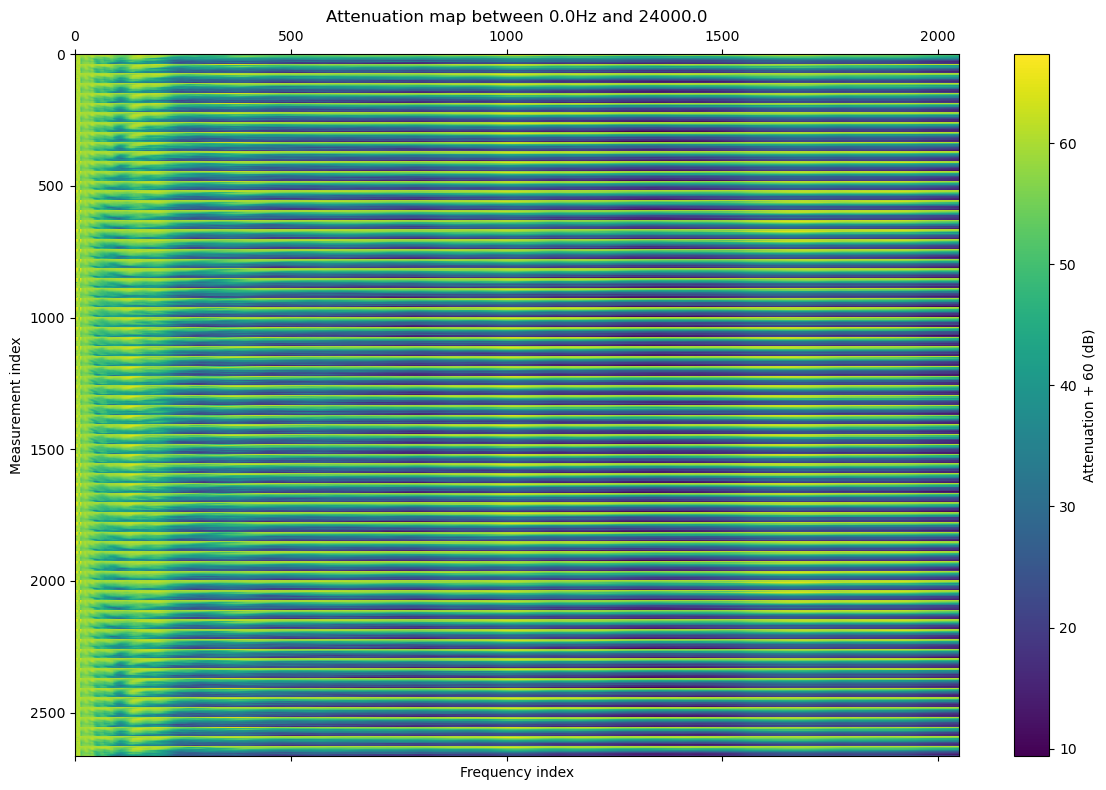

In [19]:
create_spl_heatmap(FR)

In [20]:
FR_polares= data_frame_solo_polares(FR)

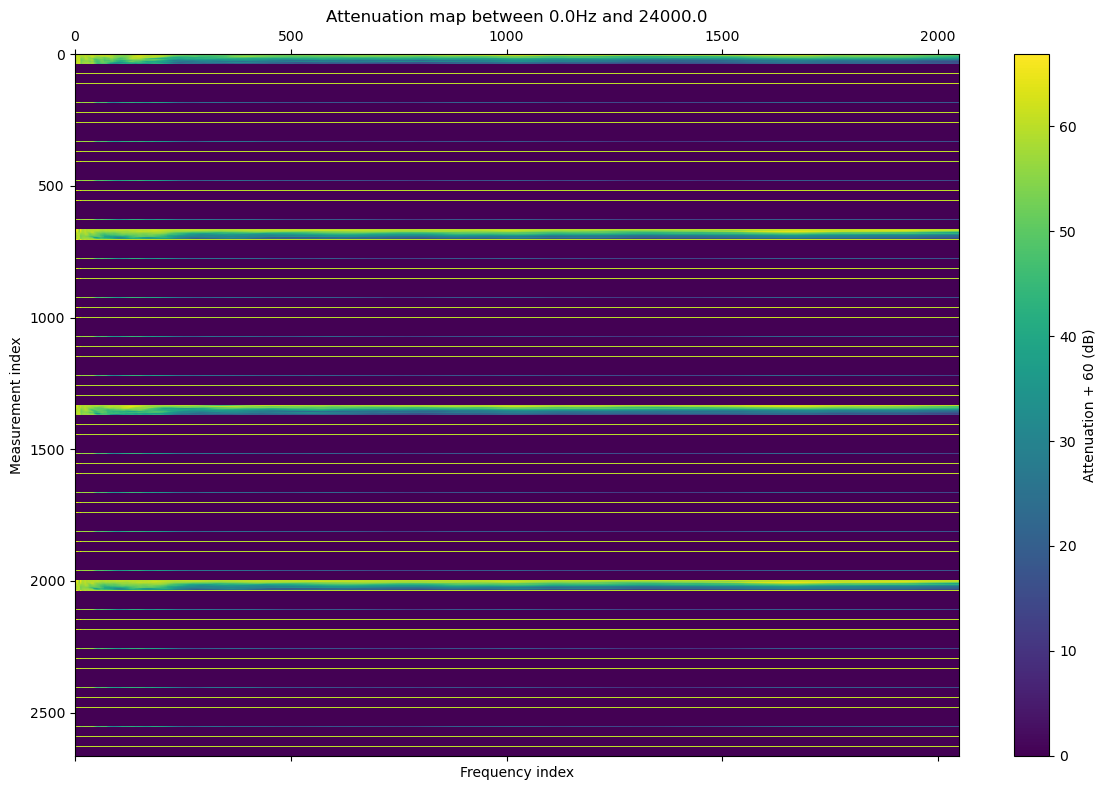

In [21]:
create_spl_heatmap(FR_polares)

In [22]:
calcular_frecuencias_iso_octava(100, 20000,3)

[100.0,
 125.99210498948732,
 158.74010519681994,
 200.0,
 251.98420997897463,
 317.4802103936399,
 400.0,
 503.96841995794927,
 634.9604207872798,
 800.0,
 1007.9368399158985,
 1269.9208415745595,
 1600.0,
 2015.873679831797,
 2539.841683149119,
 3200.0,
 4031.747359663594,
 5079.683366298238,
 6400.0,
 8063.494719327188,
 10159.366732596476,
 12800.0,
 16126.989438654376]

In [23]:
n=1

frecuencias_seleccionadas = seleccionar_frecuencias_proximas_a_iso(freq, n, 100, 20000)

# Imprimir las frecuencias seleccionadas
print(frecuencias_seleccionadas)

[105.46875, 199.21875, 398.4375, 796.875, 1605.46875, 3199.21875, 6398.4375, 12796.875]


In [24]:
n = 6  # 1/24 de octava

frecuencias_seleccionadas = seleccionar_frecuencias_proximas_a_iso(freq, n, 100, 20000)

# Imprimir las frecuencias seleccionadas
print(frecuencias_seleccionadas)

[105.46875, 117.1875, 128.90625, 140.625, 164.0625, 175.78125, 199.21875, 222.65625, 257.8125, 281.25, 316.40625, 351.5625, 398.4375, 445.3125, 503.90625, 562.5, 632.8125, 714.84375, 796.875, 902.34375, 1007.8125, 1136.71875, 1265.625, 1429.6875, 1605.46875, 1792.96875, 2015.625, 2261.71875, 2542.96875, 2847.65625, 3199.21875, 3597.65625, 4031.25, 4523.4375, 5074.21875, 5707.03125, 6398.4375, 7183.59375, 8062.5, 9046.875, 10160.15625, 11402.34375, 12796.875, 14367.1875, 16125.0, 18105.46875]


In [25]:
# Ejemplo de uso:
# Supongamos que tienes un DataFrame llamado 'df' y quieres seleccionar las frecuencias ISO 1/24 de octava
# en el rango de 20 a 20000 Hz.
n = 6
fmin = 100
fmax = 20000

df_resultante = seleccionar_columnas_frecuencias_iso(FR, n, 100, 20000)

In [26]:
df_resultante.columns

Index(['Phi', 'Theta', 'x', 'y', 'z', '105.46875', '117.1875', '128.90625',
       '140.625', '164.0625', '175.78125', '199.21875', '222.65625',
       '257.8125', '281.25', '316.40625', '351.5625', '398.4375', '445.3125',
       '503.90625', '562.5', '632.8125', '714.84375', '796.875', '902.34375',
       '1007.8125', '1136.71875', '1265.625', '1429.6875', '1605.46875',
       '1792.96875', '2015.625', '2261.71875', '2542.96875', '2847.65625',
       '3199.21875', '3597.65625', '4031.25', '4523.4375', '5074.21875',
       '5707.03125', '6398.4375', '7183.59375', '8062.5', '9046.875',
       '10160.15625', '11402.34375', '12796.875', '14367.1875', '16125.0',
       '18105.46875'],
      dtype='object')

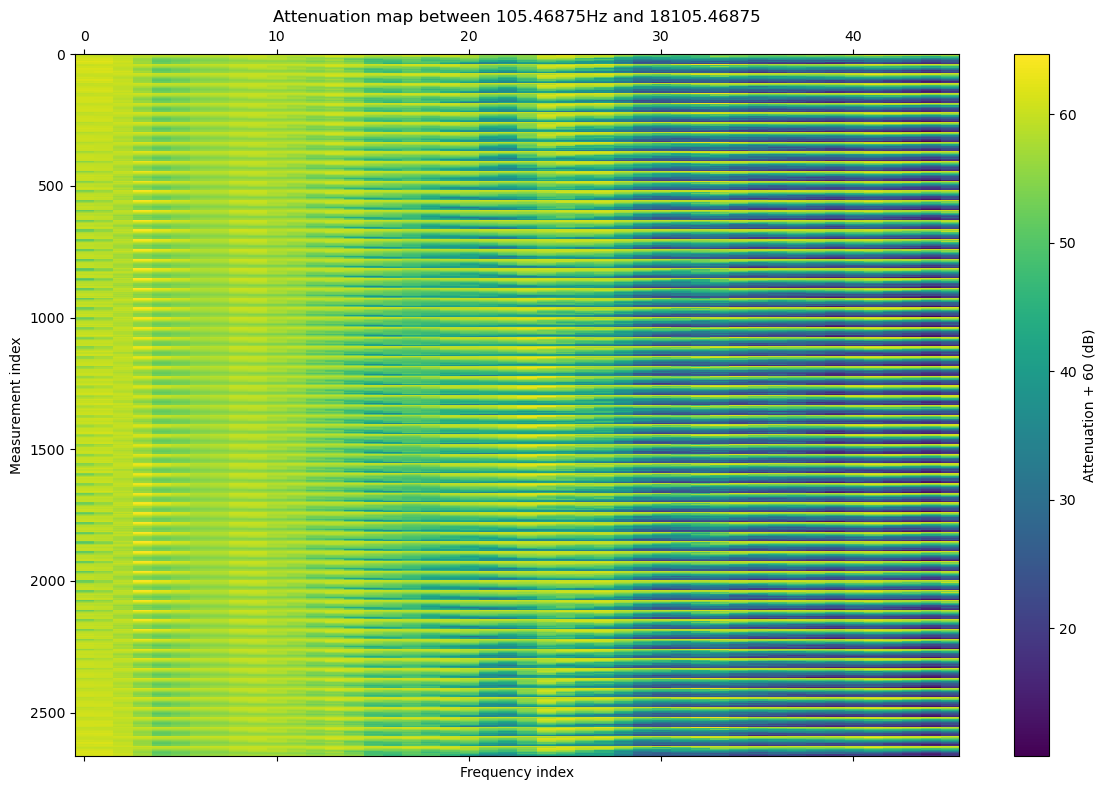

In [27]:
create_spl_heatmap(df_resultante)

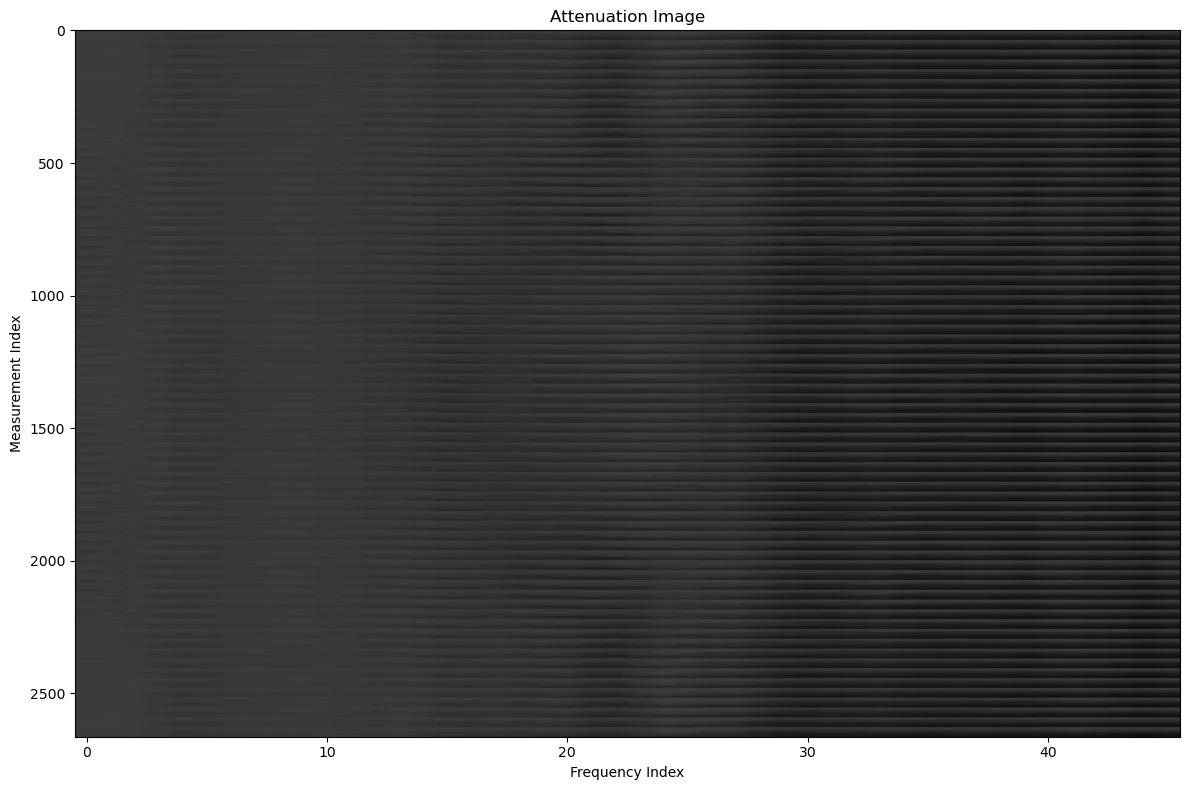

In [28]:
image = create_spl_image(df_resultante)

### Recolección de datos
Importamos las mediciones de radiación del altavoz.
Se utiliza una función contenida en "Funciones_big_data_v31.py"
Le pasamos el path y la resolución angular de las medidas.

In [82]:
import glob
 


C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 0.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 1000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 1500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 2000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 2500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\artec 310.96 3D export\artec 310.96 3D export\/IR 0 3000.txt
C:\Users\vcatala\OneDriv

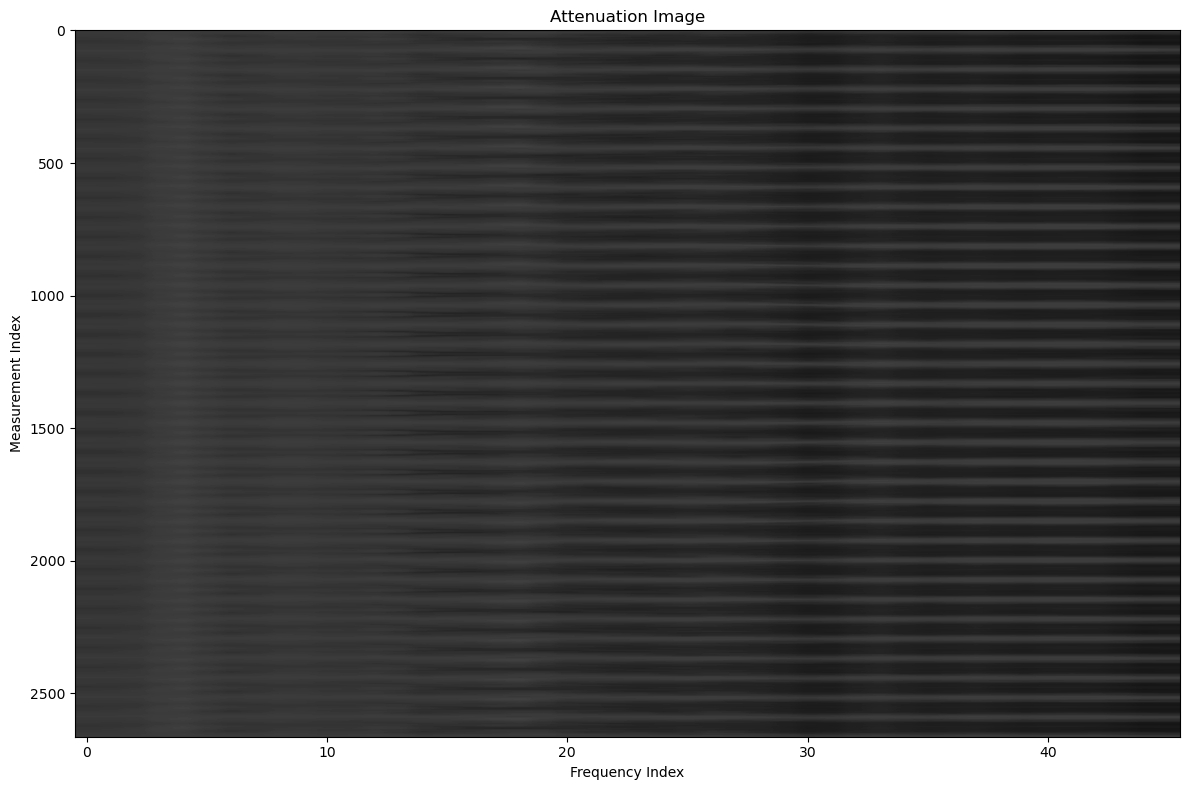

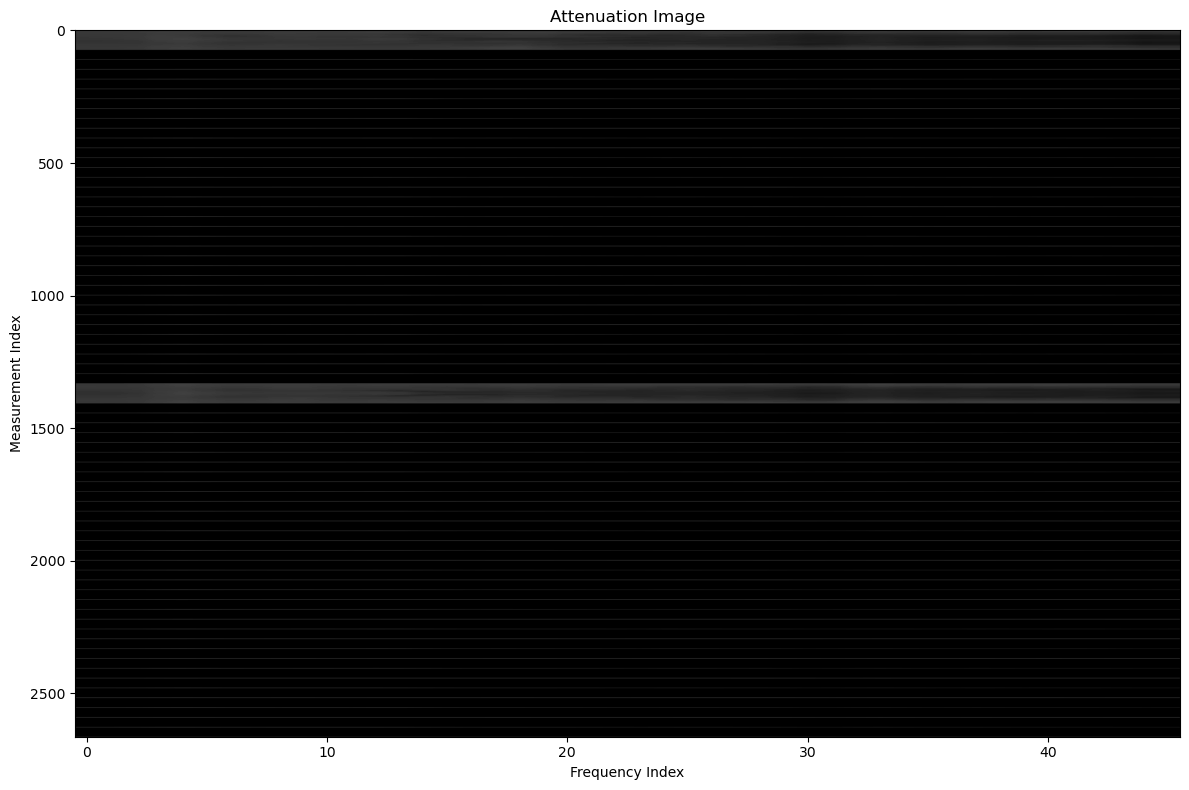

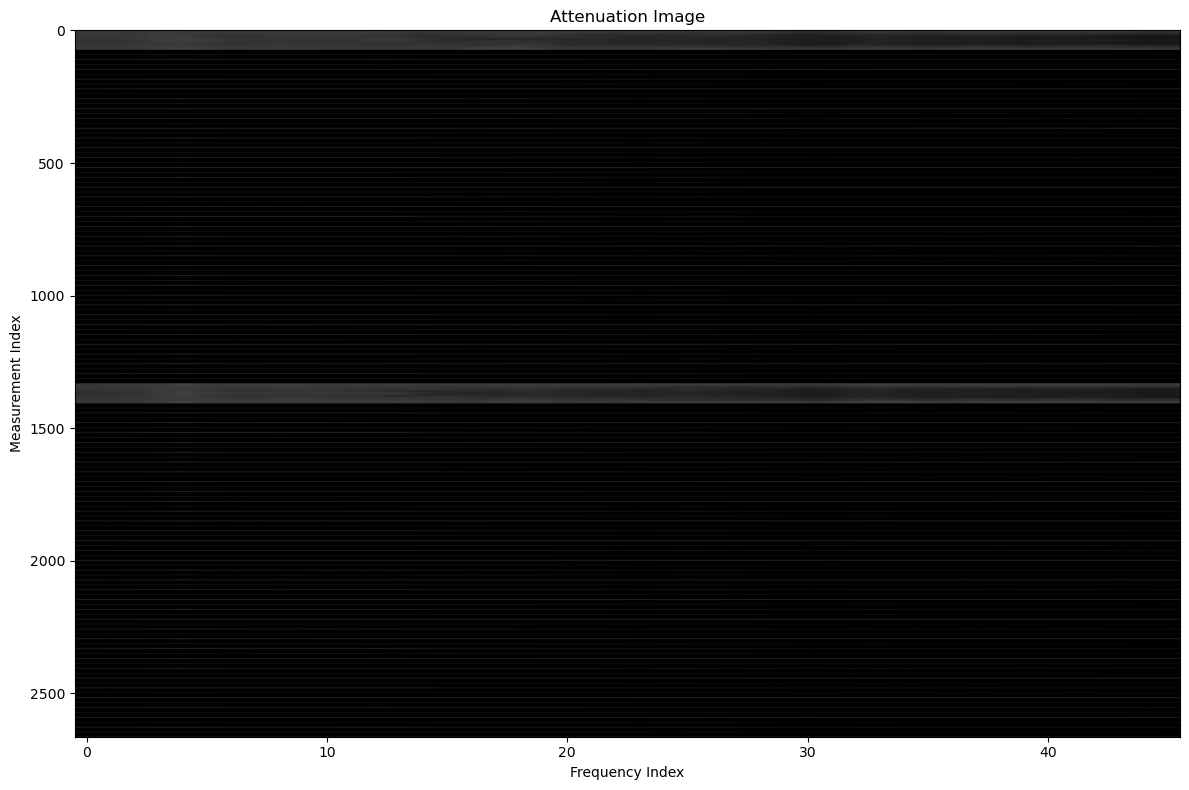

In [31]:
# primero buscamos la ubicación de la carpeta de Onedrive que incluye la carpeta 3D Clio

import os
import glob
import copy
from PIL import Image


# metemos el path a la carpeta donde tenemos todos los datos de los altavoces
# rootdir = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\'
rootdir = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\artec 310.96 3D export\\'
resolution =  5
fft_size_value =  4096
sampling_rate =  48000

generar_imagenes(rootdir, resolution, fft_size_value, sampling_rate, 'espiral', 1)





        
        

C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 0.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 1000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 1500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 2000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 2500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 3000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 3500.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 4000.txt
C:\Users\vcatala\OneDrive\PhD UV\Artículos\3D clio\Test set\EVENT 208A\/IR 0 4500.txt


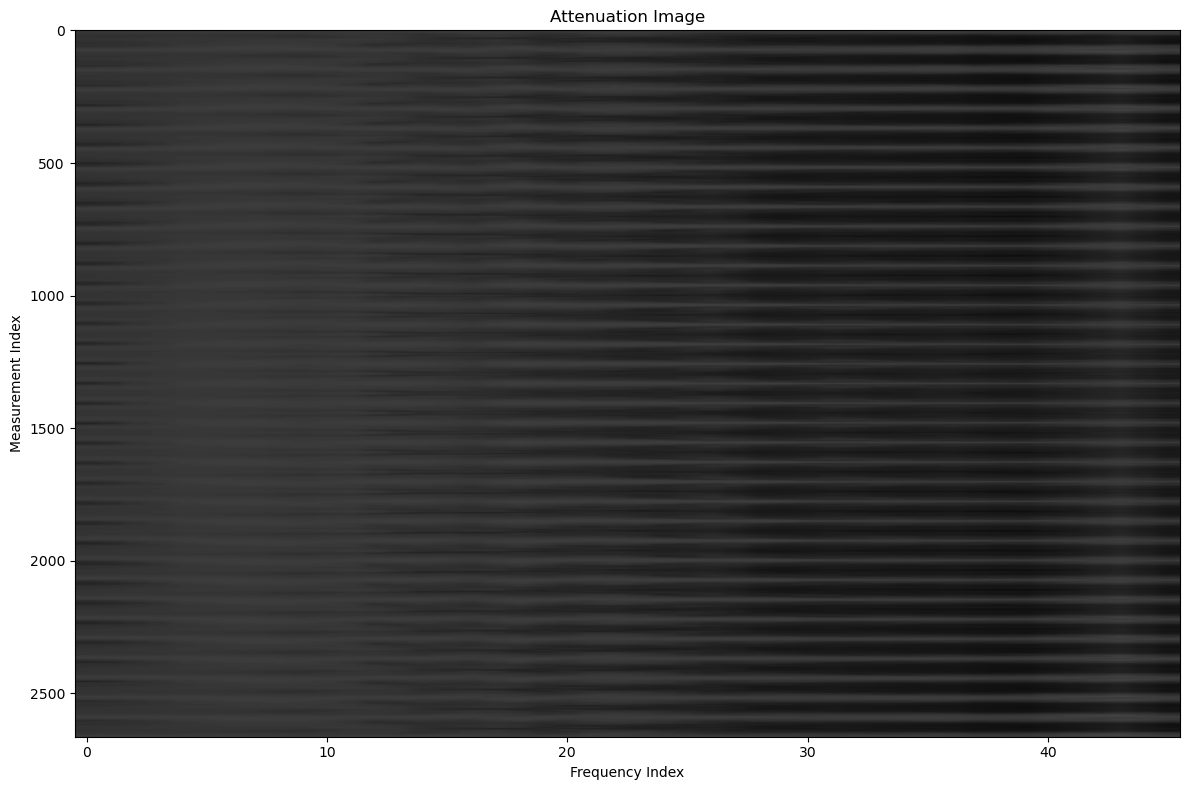

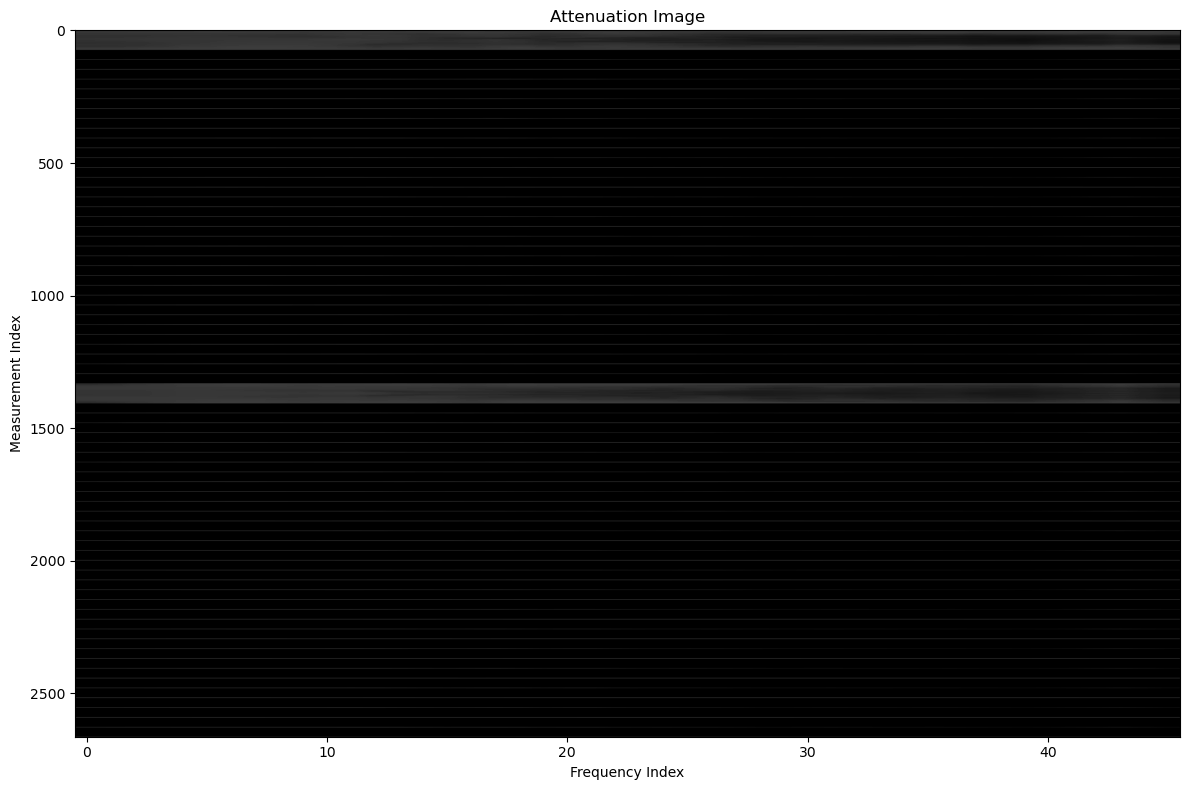

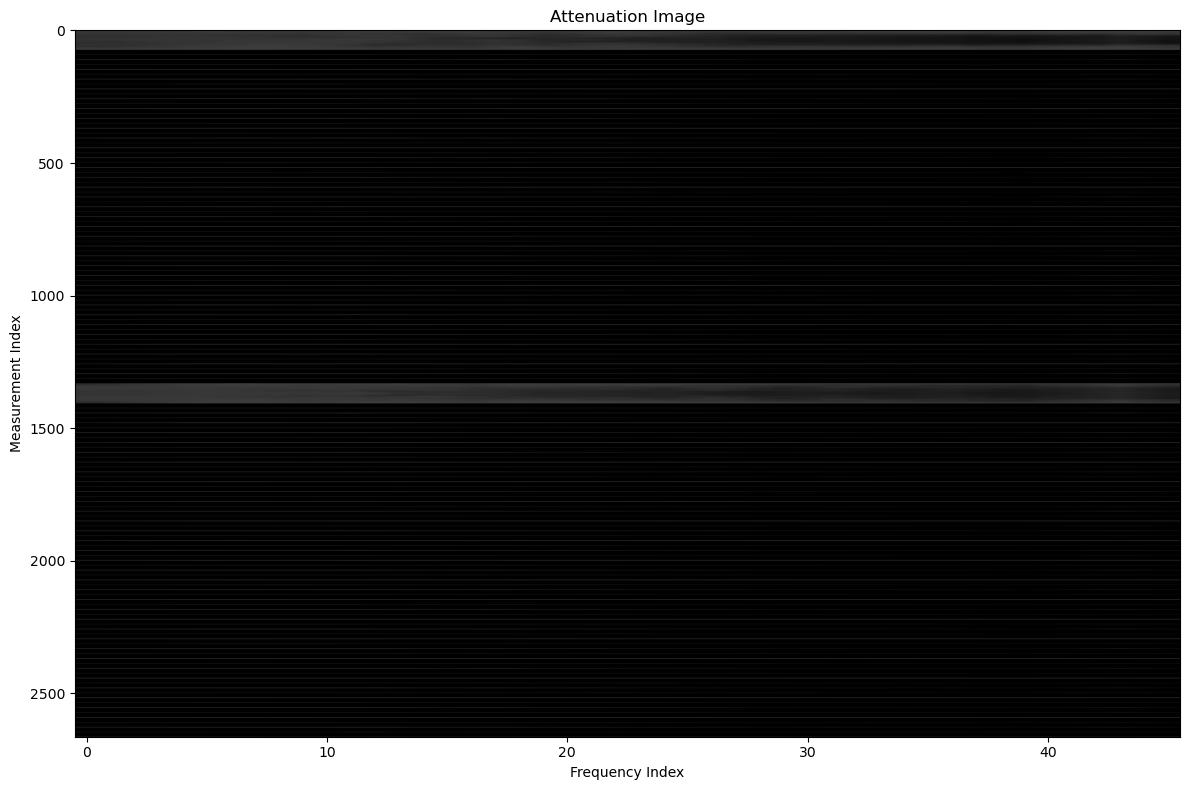

In [84]:

# Uso de la función
root_directory = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\Test set\\'
resolution =  5
fft_size_value =  4096
sampling_rate =  48000

generar_imagenes(root_directory, resolution, fft_size_value, sampling_rate, mode='espiral', verbose=1)

In [85]:
root_directory = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\Test set\\EVENT 208A'
x_test, y_test = cargar_dataset(root_directory,'espiral')


salidas
1_esp.png
espiral
entradas
1_esp_op.png
espiral


In [86]:
esp_1=y_test[0]

In [87]:
esp_1_op=x_test[0]

In [88]:
root_directory = 'C:\\Users\\vcatala\\OneDrive\\PhD UV\\Artículos\\3D clio\\Test set\\EVENT 208A'
x_test, y_test = cargar_dataset(root_directory,'normal')

salidas
1.png
normal
entradas
1_esp_90_op.png
normal
entradas
1_op.png
normal


In [89]:
normal_1=y_test[0]
normal_1_op=x_test[0]

In [90]:
input_image_df_2 = image_to_dataframe_espiral(esp_1)

(2664, 49)
row = 0
Phi = 0
Theta = 0
row = 1
Phi = 0
Theta = 5
row = 2
Phi = 0
Theta = 10
row = 3
Phi = 0
Theta = 15
row = 4
Phi = 0
Theta = 20
row = 5
Phi = 0
Theta = 25
row = 6
Phi = 0
Theta = 30
row = 7
Phi = 0
Theta = 35
row = 8
Phi = 0
Theta = 40
row = 9
Phi = 0
Theta = 45
row = 10
Phi = 0
Theta = 50
row = 11
Phi = 0
Theta = 55
row = 12
Phi = 0
Theta = 60
row = 13
Phi = 0
Theta = 65
row = 14
Phi = 0
Theta = 70
row = 15
Phi = 0
Theta = 75
row = 16
Phi = 0
Theta = 80
row = 17
Phi = 0
Theta = 85
row = 18
Phi = 0
Theta = 90
row = 19
Phi = 0
Theta = 95
row = 20
Phi = 0
Theta = 100
row = 21
Phi = 0
Theta = 105
row = 22
Phi = 0
Theta = 110
row = 23
Phi = 0
Theta = 115
row = 24
Phi = 0
Theta = 120
row = 25
Phi = 0
Theta = 125
row = 26
Phi = 0
Theta = 130
row = 27
Phi = 0
Theta = 135
row = 28
Phi = 0
Theta = 140
row = 29
Phi = 0
Theta = 145
row = 30
Phi = 0
Theta = 150
row = 31
Phi = 0
Theta = 155
row = 32
Phi = 0
Theta = 160
row = 33
Phi = 0
Theta = 165
row = 34
Phi = 0
Theta = 170
row = 

C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Phi'].iloc[row]=phi
C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Theta'].iloc[row]=theta
C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'].iloc[row]=np.array(cos(deg2rad(

row = 685
Phi = 45
Theta = 95
row = 686
Phi = 45
Theta = 100
row = 687
Phi = 45
Theta = 105
row = 688
Phi = 45
Theta = 110
row = 689
Phi = 45
Theta = 115
row = 690
Phi = 45
Theta = 120
row = 691
Phi = 45
Theta = 125
row = 692
Phi = 45
Theta = 130
row = 693
Phi = 45
Theta = 135
row = 694
Phi = 45
Theta = 140
row = 695
Phi = 45
Theta = 145
row = 696
Phi = 45
Theta = 150
row = 697
Phi = 45
Theta = 155
row = 698
Phi = 45
Theta = 160
row = 699
Phi = 45
Theta = 165
row = 700
Phi = 45
Theta = 170
row = 701
Phi = 45
Theta = 175
row = 702
Phi = 45
Theta = 180
row = 740
Phi = 50
Theta = 0
row = 741
Phi = 50
Theta = 5
row = 742
Phi = 50
Theta = 10
row = 743
Phi = 50
Theta = 15
row = 744
Phi = 50
Theta = 20
row = 745
Phi = 50
Theta = 25
row = 746
Phi = 50
Theta = 30
row = 747
Phi = 50
Theta = 35
row = 748
Phi = 50
Theta = 40
row = 749
Phi = 50
Theta = 45
row = 750
Phi = 50
Theta = 50
row = 751
Phi = 50
Theta = 55
row = 752
Phi = 50
Theta = 60
row = 753
Phi = 50
Theta = 65
row = 754
Phi = 50
Theta 

C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Phi'].iloc[row]=phi
C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Theta'].iloc[row]=theta
C:\Users\vcatala\AppData\Local\Temp\ipykernel_19580\2024738648.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'].iloc[row]=np.array(cos(deg2rad(

row = 709
Phi = 225
Theta = 150
row = 710
Phi = 225
Theta = 145
row = 711
Phi = 225
Theta = 140
row = 712
Phi = 225
Theta = 135
row = 713
Phi = 225
Theta = 130
row = 714
Phi = 225
Theta = 125
row = 715
Phi = 225
Theta = 120
row = 716
Phi = 225
Theta = 115
row = 717
Phi = 225
Theta = 110
row = 718
Phi = 225
Theta = 105
row = 719
Phi = 225
Theta = 100
row = 720
Phi = 225
Theta = 95
row = 721
Phi = 225
Theta = 90
row = 722
Phi = 225
Theta = 85
row = 723
Phi = 225
Theta = 80
row = 724
Phi = 225
Theta = 75
row = 725
Phi = 225
Theta = 70
row = 726
Phi = 225
Theta = 65
row = 727
Phi = 225
Theta = 60
row = 728
Phi = 225
Theta = 55
row = 729
Phi = 225
Theta = 50
row = 730
Phi = 225
Theta = 45
row = 731
Phi = 225
Theta = 40
row = 732
Phi = 225
Theta = 35
row = 733
Phi = 225
Theta = 30
row = 734
Phi = 225
Theta = 25
row = 735
Phi = 225
Theta = 20
row = 736
Phi = 225
Theta = 15
row = 737
Phi = 225
Theta = 10
row = 738
Phi = 225
Theta = 5
row = 739
Phi = 225
Theta = 0
row = 777
Phi = 230
Theta = 18

In [91]:
input_image_df

NameError: name 'input_image_df' is not defined

In [ ]:
input_image_df.shape

(5328, 49)